# **Predicting Metastatic Potential of Breast Tissue Cells Using Spatial Transciptomics**

**Michael Akpabey**, Monica Bonilla, Douglas Maldonado-Torres, Sarah Kang, Jenni Liu, and Jan Rosa

*Department of Computational Medicine and Bioinformatics, University of Michigan, 100 Washtenaw Ave, Ann Arbor, 48109, Michigan, United States of America*

**Loading in necessary packages**

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from anndata import AnnData

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim
# import torchvision
# import torchvision.transforms as transforms
import sklearn.metrics as metrics
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from scipy.spatial import KDTree

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.1.1+cu121  Device: cpu


# Read in and pre-process original dataset: 10xGenomics:

In [3]:
#### Read in adata

adata = sc.read_h5ad('../test3.h5ad')

In [4]:
#### Read in tissue position locations

df = pd.read_csv('../tissue_positions.csv')
df = df[df['in_tissue']!=0]
df.set_index('barcode',inplace=True)

#### Add the coordinates to the obs of adata
adata.obs['array_row'] = df['array_row']
adata.obs['array_col'] = df['array_col']

#### Read in spatial data (gene expression per barcode-spot)
spatial = pd.read_csv('../spatial.csv',index_col=0)
spatial = spatial.transpose()
genes = list(spatial.columns)

#### Create a new AnnData object with gene expression matrix.
new_adata = AnnData(obs=adata.obs,var=genes)
new_adata.X = spatial.values
new_adata

AnnData object with n_obs × n_vars = 1657 × 15013
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'manual_clusters', 'array_row', 'array_col'
    var: 0

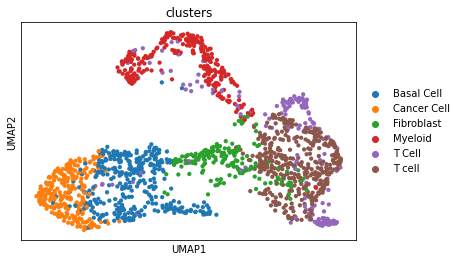

In [5]:
#### Annotate clusters with new annotation for cells

cluster_annotations = pd.read_csv('../cluster_annot.csv',index_col=0)
new_adata.obs['clusters'] = pd.Categorical(cluster_annotations['test.meta.data.manual_clusters'])

new_adata.obsm['X_umap'] = adata.obsm['X_umap']
sc.pl.umap(new_adata, color = 'clusters')

#### Rename adata.
adata = new_adata.copy()
#reassigan the gene names to adata.var_names
adata.var_names = list(adata.var[0])

In [6]:
#### Assign binary cancer classification

clusters = list(adata.obs['clusters'])
binary_classification = [1 if i == 'Cancer Cell' else 0 for i in clusters]
adata.obs['binary_classification'] = binary_classification
# adata.obs

# Start ML pipeline

# Create Data input (for GCN model)

- Assign binary cancer classification
- Select Features (Spatial coordinates and ECM_matrix or full gene expression matrix)
- Create Graph Network
- Create model input features (edges, features, labels)
- Final data 

In [7]:
#### Store spatial coordinates

array_row = np.array(adata.obs['array_row'])
array_col = np.array(adata.obs['array_col'])
points = np.column_stack((array_col, array_row))

In [8]:
#### Gene features:


#### (1) Create ECM matrix

# add the genes features to the model
# extract ECM signature genes
ecm_genes = ['ESR1','TP53','NF1','AKT1','KMT2C','PTEN']
# ecm_genes = ['SDC1', 'NUCB2', 'FADS2', 'AMBP', 'NDST4', ' ACSF2', 'LIN7A']  # ACSF2

#ecm_genes = ['ST6GALNAC6','BRCA1', 'BRCA2', 'SDC1', 'NUCB2', 'FADS2', 'AMBP', 'NDST4', 'LIN7A']

# Create a boolean mask indicating which genes are in the list
gene_mask = adata.var.index.isin(ecm_genes)

# Subset the AnnData object based on the mask
subset_adata = adata[:, gene_mask]
ecm_matrix = subset_adata.X

#### (2) Full Expression Matrix
full_expression_matrix = adata.X  # shape: (1657, 15013)

In [9]:
pd.DataFrame(ecm_matrix)

,0,1,2,3,4,5
0,3.663562,1.609438,0.000000,2.639057,2.079442,0.693147
1,3.737670,1.098612,0.693147,2.833213,1.945910,0.693147
2,3.737670,2.079442,0.000000,2.772589,2.079442,0.000000
3,3.663562,1.386294,0.000000,2.708050,1.098612,0.693147
4,3.218876,2.079442,0.000000,2.397895,2.302585,0.000000
...,...,...,...,...,...,...
1652,3.332205,0.693147,0.693147,2.944439,1.609438,0.000000
1653,3.258097,1.386294,1.386294,2.302585,1.098612,0.000000
1654,3.526361,1.609438,0.000000,2.708050,1.098612,1.098612
1655,3.367296,1.098612,0.693147,2.833213,1.945910,0.693147


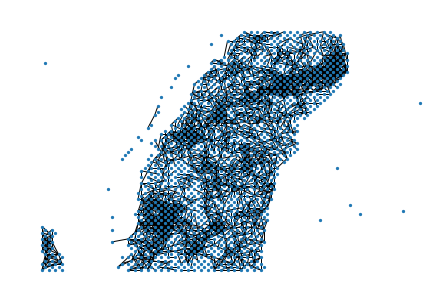

In [10]:
#### Create a graph with edges based on distance or gene correlation.


gene_expressions = ecm_matrix


# Create KDTree for spatial data
tree = KDTree(points)

# Calculate Pearson correlation matrix
gene_correlation = np.corrcoef(gene_expressions)

# Define thresholds 
distance_threshold = 5.6
correlation_threshold = 0.985 # 0.985 # 0.776  # Adjust this threshold as needed

G = nx.Graph()

# Add nodes with positions
for index, row in enumerate(points):
    G.add_node(index, pos=row)

# Add edges based on spatial and gene expression similarity
for i, point in enumerate(points):
    if i >= gene_correlation.shape[0]:
        # Skip if the index is outside the range of the gene correlation matrix
        continue

    # Spatial neighbors
    spatial_neighbors = tree.query_ball_point(point, distance_threshold)

    for j in spatial_neighbors:
        if j >= gene_correlation.shape[1]:
            # Skip if the index is outside the range of the gene correlation matrix
            continue

        if i != j and gene_correlation[i, j] >= correlation_threshold:
            G.add_edge(i, j)


pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, node_size=5, with_labels=False)
plt.show()

In [11]:
gene_correlation

array([[1.        , 0.95414111, 0.97197438, ..., 0.93639312, 0.95261344,
        0.93723817],
       [0.95414111, 1.        , 0.91519968, ..., 0.90289548, 0.99610663,
        0.96098944],
       [0.97197438, 0.91519968, 1.        , ..., 0.89070395, 0.91785617,
        0.92877606],
       ...,
       [0.93639312, 0.90289548, 0.89070395, ..., 1.        , 0.89356828,
        0.95783915],
       [0.95261344, 0.99610663, 0.91785617, ..., 0.89356828, 1.        ,
        0.95563546],
       [0.93723817, 0.96098944, 0.92877606, ..., 0.95783915, 0.95563546,
        1.        ]])

In [13]:
#### Create model Input: Graph edges, Model features, Model labels

### (1) Graph edges
edge_list = list(G.edges())

# Convert the edge list to a PyTorch tensor
edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
edge_index

#### (2) Model features
node_features = torch.tensor(adata.obs[['array_row', 'array_col']].values, dtype=torch.float)
#convert ecm matrix to torch tensors
ecm_tensor = torch.from_numpy(ecm_matrix)
# Concatenate the node features and expression matrix (our x/y and full gene expression matrix)
node_features = torch.cat((node_features,ecm_tensor),dim = 1)  # torch.Size([1657, 15015])

#### (3) Model labels
labels = torch.tensor(adata.obs['binary_classification'].values, dtype=torch.long) # tensor([1, 0, 0,  ..., 0, 0, 0])

#### Final data for GCN model:

In [14]:


data = Data(x=node_features, edge_index=edge_index, y=labels)

In [15]:
data

Data(x=[1657, 8], edge_index=[2, 3053], y=[1657])

# GCN model

In [51]:
#### Graph Convolution Network Model

class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()

        # Add the third convolutional layer
        self.conv1 = GCNConv(num_features, 32)
        self.conv2 = GCNConv(32, 64)  # Updated: Increase output channels for the second layer
        self.conv3 = GCNConv(64, num_classes)  # New layer

    def forward(self, data):
        x, edge_index = data.x.float(), data.edge_index

        # Add more layers with ReLU and Dropout
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)

        # Add the second convolutional layer
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)

        # Add the third convolutional layer
        x = self.conv3(x, edge_index)

        # Apply log_softmax to the output of the final layer
        return F.log_softmax(x, dim=1)

# Create the updated GCN model
num_features = node_features.shape[1]
num_classes = 2  # or the actual number of classes you have
model = GCN(num_features, num_classes)


In [52]:
#### Split data into Train and Test


from sklearn.model_selection import train_test_split

# Splitting the data into training and test sets
num_nodes = data.num_nodes
train_indices, test_indices = train_test_split(
    np.arange(num_nodes),
    test_size=0.2,
    stratify=labels.numpy(),
    random_state=32  # for reproducibility
)

# Then create the masks as shown previously
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True
test_mask[test_indices] = True

# Add masks to the data object
data.train_mask = train_mask
data.test_mask = test_mask


**Training the model**

In [53]:
#### Train Model

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4) 
losses = []
epochs = []
accuracies = []
model.train()
for epoch in range(25000):
    optimizer.zero_grad()
    out = model(data)
    # Convert target values to Long type
    target = data.y[data.train_mask].long()
    loss = F.nll_loss(out[data.train_mask], target)
    loss.backward()
    optimizer.step()
    
    # Calculate accuracy
    _, predicted = out.max(dim=1)
    correct = predicted[data.train_mask].eq(target).sum().item()
    total = data.train_mask.sum().item()
    accuracy = correct / total
    
    # Store loss, accuracy, and epoch number
    losses.append(loss.item())
    accuracies.append(accuracy)
    epochs.append(epoch)
    
    # Print epoch number, loss, and accuracy
    #print(f'Epoch {epoch + 1}: Loss = {loss.item():.4f}, Accuracy = {accuracy:.4f}')

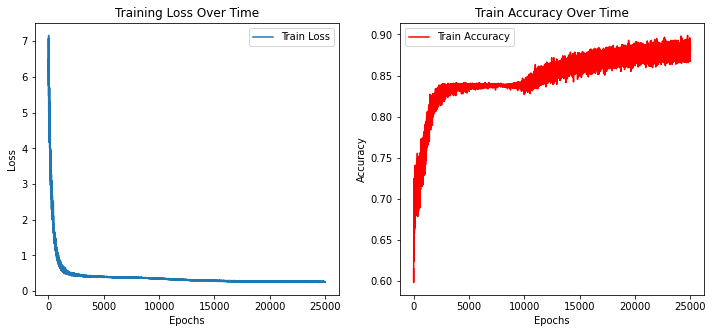

Train accuracy is: 0.8822641509433963
Train loss is: 0.25423547625541687


In [54]:
#### Training Loss and Testing accuracy Plots


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()

# Plotting the test accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Train Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train Accuracy Over Time')
plt.legend()

plt.show()

print('Train accuracy is:', accuracies[-1])
print('Train loss is:', losses[-1])

In [55]:
 from sklearn.metrics import confusion_matrix, accuracy_score
# Assuming data.y and pred are your ground truth and predicted labels
conf_matrix = confusion_matrix(data.y, predicted)
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

for i, acc in enumerate(class_accuracies):
    print(f'Accuracy for class {i}: {acc * 100:.2f}%')

total_accuracy = accuracy_score(data.y, predicted)
print(f'Total Accuracy: {total_accuracy * 100:.2f}%')

Accuracy for class 0: 95.18%
Accuracy for class 1: 51.12%
Total Accuracy: 88.05%


In [56]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8705


**Using ROC curve for the assessement of how well our model performs**

In [57]:
model.eval()
with torch.no_grad():
    val_out = model(data)


In [58]:
from sklearn.metrics import roc_curve, auc

val_target = data.y[data.test_mask].long()
scores = F.softmax(val_out[data.test_mask], dim=1)[:, 1].cpu().numpy()  # Assuming 2 classes and getting probabilities for class 1

fpr, tpr, _ = roc_curve(val_target.cpu().numpy(), scores)
roc_auc = auc(fpr, tpr)

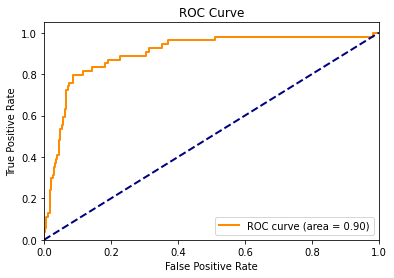

In [59]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [33]:
data

Data(x=[1657, 8], edge_index=[2, 3053], y=[1657], train_mask=[1657], test_mask=[1657])

In [60]:
torch.save(model.state_dict(), 'spatial_GCN_FINAL.pth')

In [245]:
torch.save(model.state_dict(), 'GCN_combined_genes.pth')